Underfitting
    - too simple to explain the data 

Optimal fit
    - not perfect, but will predict new data decently well

Overfitting
    - too good to be true (100% accuracy in a decision tree, too filtered down)
    - future data won't be accurate
    - including features that don't really apply

To avoid under/overfitting, we want to get rid of bad features

Feature Importance Measures
- VIF- tells us which overlap
- p- 
- t- 
- Coef- 

- R2- 
- MAE- 
- RMSEA- 
- Accuracy-
- Precision-
- Recall-
- F-

- pearson-
- ANOVA-
- correlation- 

In [9]:
def import_data(path, messages=True):
  import pandas as pd
  df = pd.read_csv(path)
  if messages: print(df.shape)
  return df
        
def bin_groups(df, features=[], cutoff=0.05, replace_with='Other', messages=True):
  import pandas as pd
  if len(features) == 0: features = df.columns
  for feat in features:
    if feat in df.columns:  # Make sure they don't accidentally enter a feature name that doesn't exist
      if not pd.api.types.is_numeric_dtype(df[feat]):
        other_list = df[feat].value_counts()[df[feat].value_counts() / df.shape[0] < cutoff].index
        df.loc[df[feat].isin(other_list), feat] = replace_with
        if messages and len(other_list) > 0: print(f'{feat} has been binned by setting {other_list.values} to {replace_with}')
    else:
      if messages: print(f'{feat} not found in the DataFrame provided. No binning performed')
  return df
        
def missing_drop(df, label, row_thresh=0.7, col_thresh=0.9, drop_all=False):
  df.dropna(axis='rows', subset=[label], inplace=True)
  df.dropna(axis='columns', thresh=1, inplace=True)
  df.dropna(axis='rows', thresh=1, inplace=True)
  df.dropna(axis='columns', thresh=round(df.shape[0] * row_thresh), inplace=True)
  df.dropna(axis='rows', thresh=round(df.shape[1] * col_thresh), inplace=True)
  if drop_all: df.dropna(axis='rows', inplace=True)
  return df
  
def Xandy(df, label):
  import pandas as pd
  y = df[label]
  X = df.drop(columns=[label])
  return X, y
  
def dummy_code(X):
  import pandas as pd
  X = pd.get_dummies(X, drop_first=True)
  return X
  
def minmax(X):
  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler
  X = pd.DataFrame(MinMaxScaler().fit_transform(X.copy()), columns=X.columns, index=X.index)
  return X
        
def impute_KNN(df, label, neighbors=5):
  from sklearn.impute import KNNImputer
  import pandas as pd
  X, y = Xandy(df, label)
  X = dummy_code(X.copy())
  X = minmax(X.copy())
  imp = KNNImputer(n_neighbors=neighbors, weights="uniform")
  X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
  return X.merge(y, left_index=True, right_index=True)
        
def fit_cv_regression(df, k, label, repeat=True, algorithm='ensemble', random_state=1, messages=True):
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean
  X, y = Xandy(df, label)
  X = dummy_code(X)
  if repeat:  cv = RepeatedKFold(n_splits=k, n_repeats=5, random_state=12345)
  else:       cv = KFold(n_splits=k, random_state=12345, shuffle=True)
  if algorithm == 'linear':
    from sklearn.linear_model import Ridge, LassoLars
    model1 = Ridge(random_state=random_state)
    model2 = LassoLars(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  elif algorithm == 'ensemble':
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    model1 = RandomForestRegressor(random_state=random_state)
    model2 = GradientBoostingRegressor(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  else:
    from sklearn.neural_network import MLPRegressor
    from sklearn.neighbors import KNeighborsRegressor
    model1 = MLPRegressor(random_state=random_state, max_iter=10000)
    model2 = KNeighborsRegressor()
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  if messages:
    print('R2', '{: <25}'.format(type(model1).__name__), round(score1, 4))
    print('R2', '{: <25}'.format(type(model2).__name__), round(score2, 4))
  if score1 > score2: return model1.fit(X, y)
  else:               return model2.fit(X, y)

In [10]:
def bivariate(df, label, roundto=4):
    import pandas as pd, numpy as np
    from scipy import stats
        
    output_df = pd.DataFrame(columns=['unique', 'sign', 'r', 'ρ', 'τ'])
        
    for feature in df.columns:
        if feature != label:                    # Don't need the relationship fo the label with itself
            df_temp = df[[feature, label]]      # Make a version of the DataFrame with only the feature and label
            df_temp = df_temp.dropna()          # Drop missing rows from that DataFrame
            unique = df_temp[feature].nunique() # Knowing the n unique values will help determine which corr metrics to use

        r, p = stats.pearsonr(df_temp[feature], df_temp[label])
        rho, rp = stats.spearmanr(df_temp[feature], df_temp[label])
        tau, tp = stats.kendalltau(df_temp[feature], df_temp[label])
            
        if r < 0: sign = '-'  # To compare feature importance, we must convert all negative r to positive
        else:     sign = '+'  # Therefore, let's make another column to inidcate it's sign

        # Insert a record for this feature into output_df
        output_df.loc[feature] = [unique, sign, round(abs(r), roundto),  round(abs(rho), roundto), 
                                    round(abs(tau), roundto)]
    return output_df.sort_values(by=['r'], ascending=False)

    # Make a DataFrame to keep track of feature importance based on each technique we learn

df_importance = bivariate(df, 'SalePrice')
df_importance

,unique,sign,r,ρ,τ
SalePrice,2,+,1.0000,1.0000,1.0000
OverallQual,10,+,0.7898,0.8080,0.6677
TotalSF,859,+,0.7077,0.7312,0.5441
GarageCars,5,+,0.6371,0.6865,0.5682
GarageArea,441,+,0.6197,0.6449,0.4740
...,...,...,...,...,...
MiscVal,20,-,0.0143,0.0585,0.0475
BsmtFinSF2,144,-,0.0132,0.0419,0.0332
RoofStyle_Other,2,-,0.0060,0.0124,0.0101
LotConfig_Other,2,-,0.0026,0.0148,0.0121


R2 Ridge                     0.8135
R2 LassoLars                 0.8021


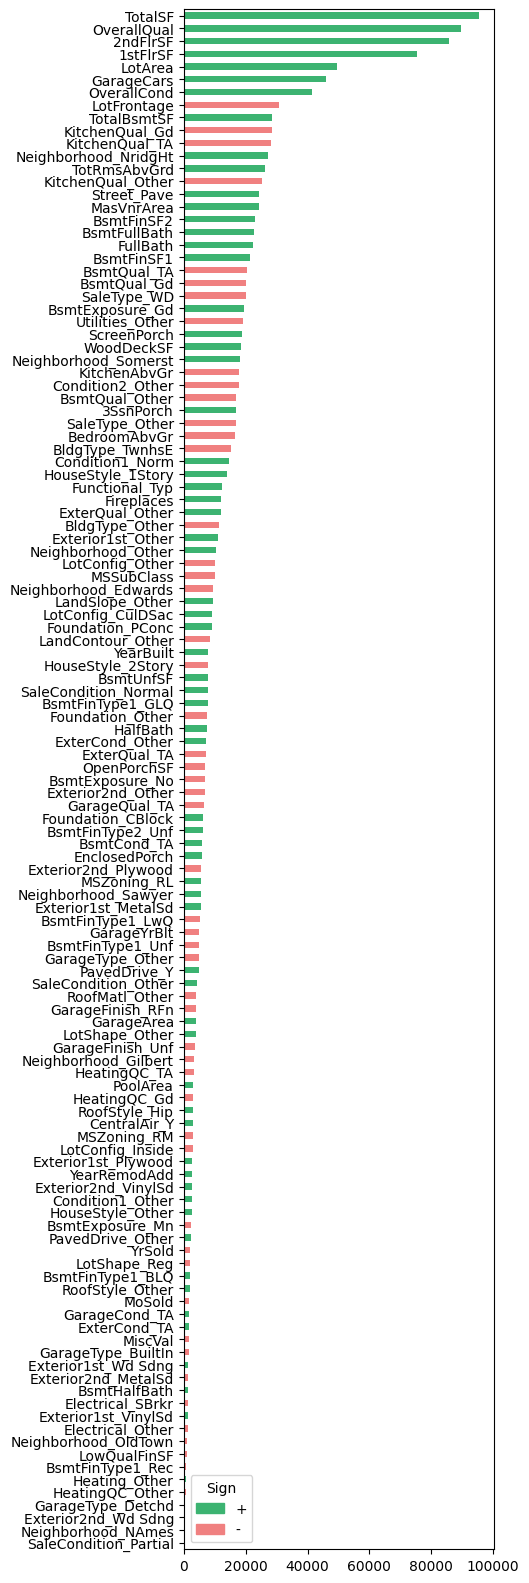

,unique,sign,r,ρ,τ,Coefficients,sign_coef
OverallQual,10,+,0.7898,0.8080,0.6677,89453.933930,+
TotalSF,859,+,0.7077,0.7312,0.5441,95384.703781,+
GarageCars,5,+,0.6371,0.6865,0.5682,45925.816072,+
GarageArea,441,+,0.6197,0.6449,0.4740,3896.155474,+
TotalBsmtSF,721,+,0.6098,0.5975,0.4305,28487.283826,+
...,...,...,...,...,...,...,...
MiscVal,20,-,0.0143,0.0585,0.0475,1638.249321,-
BsmtFinSF2,144,-,0.0132,0.0419,0.0332,22950.467391,+
RoofStyle_Other,2,-,0.0060,0.0124,0.0101,1935.651170,+
LotConfig_Other,2,-,0.0026,0.0148,0.0121,10255.846061,-


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

# Create a model based on the linear algorithm with the highest fit metric
model = fit_cv_regression(df, 10, label, algorithm='linear', messages=False)

# Store the coefficients of that model in a new DataFrame
df_coef = pd.DataFrame({'Coefficients':model.coef_}, index=model.feature_names_in_)
df_coef['sign'] = '+'           # Add a column to indicate sign; default to positive
for coef in df_coef.itertuples(): # Set each coefficient to the abs() and store the sign
    if coef[1] < 0:                 # If it's negative, change to positive and store sign
        df_coef.at[coef[0], 'sign'] = '-'
        df_coef.at[coef[0], 'Coefficients'] = coef[1] * -1

df_coef.sort_values(by=['Coefficients'], inplace=True)  # Sort the results for the image
plt.figure(figsize=(4,20))                              # Set the size of the image              

# Plot the coefficients in a bar chart separately for positive vs negative with diff colors
colors = {'+': 'mediumseagreen', '-': 'lightcoral'}
df_coef['Coefficients'].plot(kind='barh', color=[colors[i] for i in df_coef['sign']])

# Create the plot legend
labels = df_coef['sign'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Sign")
plt.show()

# Store the coefficients in our df_importance table for later comparison
df_importance = df_importance.merge(df_coef, left_index=True, right_index=True, suffixes=('', '_coef'))
df_importance

In [13]:
model = fit_cv_regression(df, 5, label, repeat=False, algorithm='ensemble')

fi = pd.DataFrame(model.feature_importances_, columns=['FI'], index=model.feature_names_in_)
df_importance = df_importance.merge(fi, left_index=True, right_index=True)
df_importance.sort_values(by=['FI'], ascending=False, inplace=True)
df_importance

R2 RandomForestRegressor     0.8551
R2 GradientBoostingRegressor 0.8757


,unique,sign,r,ρ,τ,Coefficients,sign_coef,FI
OverallQual,10,+,0.7898,0.8080,0.6677,89453.933930,+,0.532845
TotalSF,859,+,0.7077,0.7312,0.5441,95384.703781,+,0.140753
TotalBsmtSF,721,+,0.6098,0.5975,0.4305,28487.283826,+,0.052437
GarageCars,5,+,0.6371,0.6865,0.5682,45925.816072,+,0.051082
BsmtFinSF1,637,+,0.3829,0.2958,0.2162,21564.714713,+,0.042809
...,...,...,...,...,...,...,...,...
ExterCond_TA,2,+,0.1014,0.1203,0.0984,1708.585599,+,0.000000
PavedDrive_Other,2,-,0.0899,0.1054,0.0862,2269.551423,+,0.000000
BsmtFinType1_Unf,2,-,0.0878,0.0842,0.0689,5021.017727,-,0.000000
Foundation_Other,2,-,0.0868,0.1152,0.0942,7585.056463,-,0.000000


In [14]:
from sklearn.inspection import permutation_importance

X, y = Xandy(df, label)
result = permutation_importance(model, X, y, n_repeats=10, scoring="r2", random_state=1, n_jobs=-1)
df_pfi = pd.DataFrame({'PFI':result.importances_mean, 'PFI std':result.importances_std}, 
                    index=model.feature_names_in_)
df_importance = df_importance.merge(df_pfi, left_index=True, right_index=True)
df_importance.sort_values(by=['PFI'], ascending=False, inplace=True)
df_importance

,unique,sign,r,ρ,τ,Coefficients,sign_coef,FI,PFI,PFI std
OverallQual,10,+,0.7898,0.8080,0.6677,89453.933930,+,5.328448e-01,2.763614e-01,0.008477
TotalSF,859,+,0.7077,0.7312,0.5441,95384.703781,+,1.407526e-01,1.358197e-01,0.003357
TotalBsmtSF,721,+,0.6098,0.5975,0.4305,28487.283826,+,5.243702e-02,3.201940e-02,0.002211
BsmtFinSF1,637,+,0.3829,0.2958,0.2162,21564.714713,+,4.280862e-02,2.808618e-02,0.001352
2ndFlrSF,417,+,0.3193,0.2944,0.2333,85563.198249,+,3.365102e-02,1.802160e-02,0.000490
...,...,...,...,...,...,...,...,...,...,...
LotShape_Reg,2,-,0.2645,0.3130,0.2560,2133.012422,-,0.000000e+00,0.000000e+00,0.000000
BldgType_TwnhsE,2,+,0.0020,0.0365,0.0298,15271.291011,-,0.000000e+00,0.000000e+00,0.000000
RoofStyle_Hip,2,+,0.2391,0.1565,0.1280,3075.524172,+,2.351026e-07,-5.517081e-07,0.000001
Exterior1st_MetalSd,2,-,0.1689,0.2019,0.1651,5485.768107,+,4.714795e-05,-4.284502e-06,0.000020


In [12]:
# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('housing.csv', messages=False)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageQual_TA,GarageCond_TA,PavedDrive_Other,PavedDrive_Y,SaleType_Other,SaleType_WD,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,SalePrice
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,208500.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,181500.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,223500.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,140000.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,250000.0
